# SECTION 1: SETUP AND WHOLE-BUILDING DATA PREPARATION

Libraries imported successfully.
--- Loading Raw Floor Data ---
[SUCCESS] Loaded Floor1.csv (790560 rows)
[SUCCESS] Loaded Floor2.csv (790560 rows)
[SUCCESS] Loaded Floor3.csv (790560 rows)
[SUCCESS] Loaded Floor4.csv (790560 rows)
[SUCCESS] Loaded Floor5.csv (790560 rows)
[SUCCESS] Loaded Floor6.csv (689128 rows)
[SUCCESS] Loaded Floor7.csv (790560 rows)
--------------------------------

--- Processing and Aggregating Data for All Floors ---
Processing Floor1...
  > Missing values handled: 49456 -> 0
Processing Floor2...
  > Missing values handled: 120755 -> 0
Processing Floor3...
  > Missing values handled: 1232820 -> 0
Processing Floor4...
  > Missing values handled: 1154770 -> 0
Processing Floor5...
  > Missing values handled: 341071 -> 0
Processing Floor6...
  > Missing values handled: 27558 -> 0
Processing Floor7...
  > Missing values handled: 174160 -> 0

[SUCCESS] Building-wide hourly energy consumption profile created.
Final DataFrame shape: (13176, 8)
Final DataFrame columns:

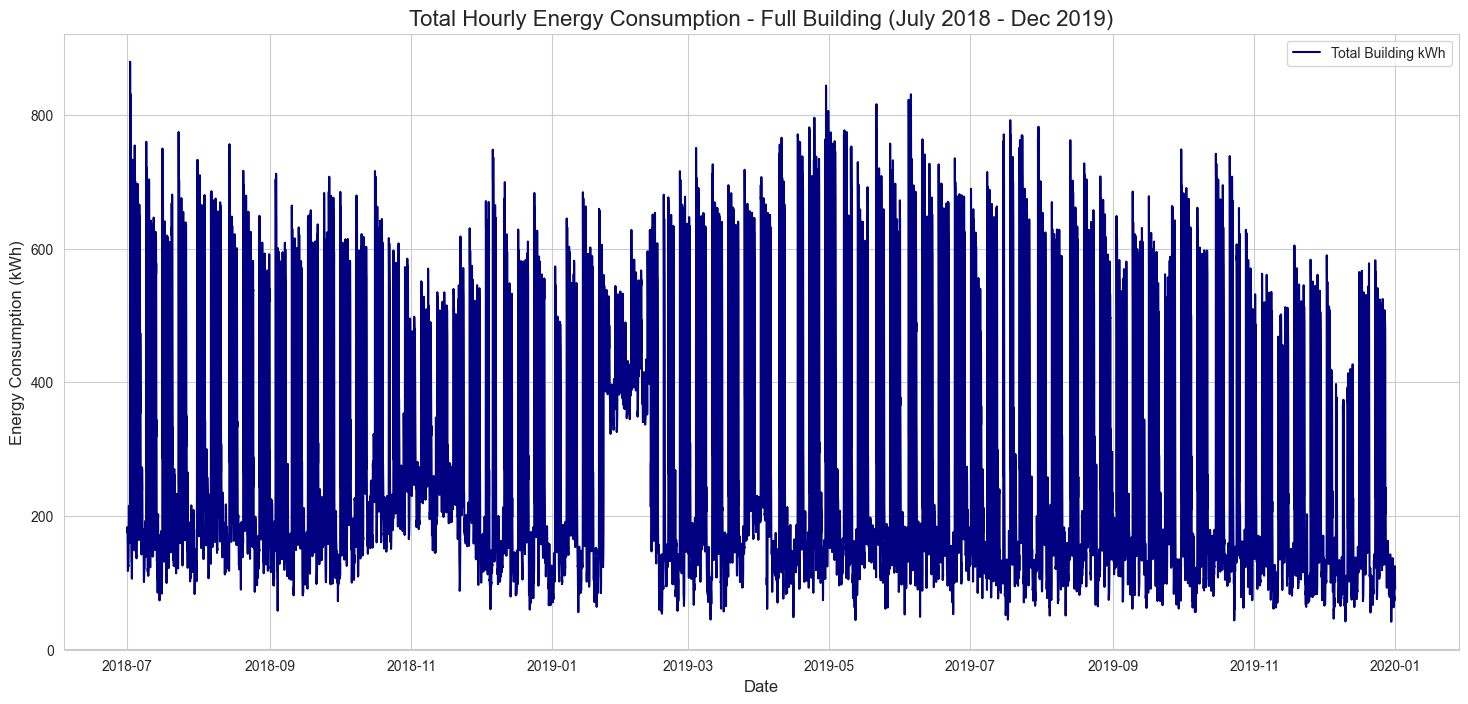


--- First 5 rows of the final building-wide dataframe ---
                     Floor1_kWh  Floor2_kWh  Floor3_kWh  Floor4_kWh  \
Date                                                                  
2018-07-01 00:00:00  155.625000    7.811667    0.643167    9.820167   
2018-07-01 01:00:00  156.687000    7.862333    0.557167    9.882667   
2018-07-01 02:00:00  156.282500    7.842500    0.578167    9.843000   
2018-07-01 03:00:00  154.346500    7.874833    0.563000    9.913000   
2018-07-01 04:00:00  162.414833    7.957833    0.580833    9.797167   

                     Floor5_kWh  Floor6_kWh  Floor7_kWh  Building_Total_kWh  
Date                                                                         
2018-07-01 00:00:00    1.066667    0.758167    0.540333          176.265167  
2018-07-01 01:00:00    1.030333    0.695167    0.587333          177.302000  
2018-07-01 02:00:00    1.100167    0.764667    0.638500          177.049500  
2018-07-01 03:00:00    1.159000    0.697833    0.5750

In [1]:
# =============================================================================
# SECTION 1: SETUP AND WHOLE-BUILDING DATA PREPARATION
# =============================================================================
#
# OBJECTIVE:
# To load the raw, minute-level energy data from all seven floors, consolidate
# them into a single, clean, hourly time-series representing the total energy
# consumption of the entire building. This will serve as the foundational
# dataset for our probabilistic forecasting task.
#
# =============================================================================


# --- 1.1. Import Core Libraries ---
#
# Import the essential libraries for data manipulation, numerical operations,
# and visualization. We set a consistent style to improve readability.
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style for consistency across all plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

print("Libraries imported successfully.")


# --- 1.2. Load All Floor Datasets ---
#
# We will load the CSV file for each of the seven floors into a dictionary.
# This approach is scalable and keeps the raw data organized. A try-except
# block ensures the code handles missing files gracefully.
#
floor_files = {f'Floor{i}': f'Floor{i}.csv' for i in range(1, 8)}
all_floors_raw = {}
print("--- Loading Raw Floor Data ---")
for floor_name, file_name in floor_files.items():
    try:
        all_floors_raw[floor_name] = pd.read_csv(file_name)
        print(f"[SUCCESS] Loaded {file_name} ({len(all_floors_raw[floor_name])} rows)")
    except FileNotFoundError:
        print(f"[ERROR] {file_name} not found. Please check the file path.")
print("--------------------------------")


# --- 1.3. Consolidate and Aggregate Building-Wide Data ---
#
# This is the core data preparation step. We will loop through each raw floor
# dataframe, clean it, resample it to hourly energy (kWh), and then
# combine all floors to create a single, building-wide time series.
#
print("\n--- Processing and Aggregating Data for All Floors ---")
all_floors_hourly_kwh = []

for floor_name, df_raw in all_floors_raw.items():
    print(f"Processing {floor_name}...")
    
    # Create a copy to avoid modifying the original raw dataframe
    df_proc = df_raw.copy()
    
    # Step 1: Standardize 'Date' column and set as index
    df_proc['Date'] = pd.to_datetime(df_proc['Date'])
    df_proc.set_index('Date', inplace=True)
    
    # Step 2: Isolate only the power consumption (kW) columns
    energy_cols = [col for col in df_proc.columns if col.endswith('(kW)')]
    df_energy = df_proc[energy_cols].copy()
    
    # Step 3: Handle missing values within each floor's data
    # ffill() followed by bfill() is a robust method for time-series imputation
    initial_missing = df_energy.isnull().sum().sum()
    df_energy.ffill(inplace=True)
    df_energy.bfill(inplace=True)
    final_missing = df_energy.isnull().sum().sum()
    print(f"  > Missing values handled: {initial_missing} -> {final_missing}")
    
    # Step 4: Sum all kW columns to get the total power for the floor
    df_energy['Total_kW'] = df_energy.sum(axis=1)
    
    # Step 5: Resample from minute-level power (kW) to hourly energy (kWh)
    # The mean power over one hour is numerically equivalent to the energy in kWh.
    df_hourly = df_energy[['Total_kW']].resample('h').mean()
    df_hourly.rename(columns={'Total_kW': f'{floor_name}_kWh'}, inplace=True)
    
    all_floors_hourly_kwh.append(df_hourly)

# Step 6: Concatenate all processed floor dataframes into one
df_building = pd.concat(all_floors_hourly_kwh, axis=1)

# Step 7: Create the final building-wide target variable
df_building['Building_Total_kWh'] = df_building.sum(axis=1)

# Step 8: Final check for any remaining missing values at the building level
if df_building['Building_Total_kWh'].isnull().any():
    print("\n[WARNING] Missing values detected after aggregation. Applying forward/backward fill.")
    df_building.ffill(inplace=True)
    df_building.bfill(inplace=True)

print("\n[SUCCESS] Building-wide hourly energy consumption profile created.")
print(f"Final DataFrame shape: {df_building.shape}")
print("Final DataFrame columns:", df_building.columns.tolist())


# --- 1.4. Initial Visualization of the Target Variable ---
#
# Before proceeding, we must visualize the final time series to understand
# its overall characteristics, such as trends, seasonality, and any
# obvious anomalies.
#
plt.figure(figsize=(18, 8))
plt.plot(df_building.index, df_building['Building_Total_kWh'], label='Total Building kWh', color='navy')
plt.title('Total Hourly Energy Consumption - Full Building (July 2018 - Dec 2019)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.legend()
plt.show()

# Display the first few rows of the final dataframe to confirm the structure
print("\n--- First 5 rows of the final building-wide dataframe ---")
print(df_building.head())
print("\n---------------------------------------------------------")

# PROJECT UTILITIES AND CUSTOM FUNCTIONS

In [2]:
# =============================================================================
# PROJECT UTILITIES AND CUSTOM FUNCTIONS
# =============================================================================
#
# OBJECTIVE:
# To define reusable functions and set global configurations to ensure
# consistency and reproducibility throughout the entire workflow.
#
# =============================================================================


# --- Utility: Global Seeds for Reproducibility ---
#
# By setting the random seeds for TensorFlow and NumPy at the start, we ensure
# that any stochastic process (e.g., model weight initialization, dropout,
# tuner search patterns) is deterministic and will produce the same results
# on every run. This is crucial for scientific validity.
#
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

print("Global random seeds for TensorFlow and NumPy have been set.")


# --- Utility: Sequence Creation Function ---
#
# This function converts our flat dataframe into sequences suitable for
# time-series models like LSTMs and Transformers.
#
def create_sequences(features, target, time_steps):
    """Converts arrays of features and a target into sequences."""
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

print("Sequence creation utility function defined.")


# --- Utility: Custom Keras Layer for Positional Encoding ---
#
# This layer is essential for the Transformer model. Since Transformers do not
# have a recurrent structure, this layer explicitly injects information
# about the position of each "patch" in the sequence.
#
class PositionalEncoding(tf.keras.layers.Layer):
    """Injects positional information into the input embeddings."""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Pre-calculates the positional encoding matrix
        pos_encoding = self.create_positional_encoding(max_len, d_model)
        self.pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def create_positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        # Apply sin to even indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # Apply cos to odd indices
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return pos_encoding

    def call(self, inputs):
        # Adds the positional encoding to the input tensor
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("PositionalEncoding custom layer defined.")

Global random seeds for TensorFlow and NumPy have been set.
Sequence creation utility function defined.
PositionalEncoding custom layer defined.


# SECTION 2: PREPROCESSING AND FEATURE ENGINEERING

In [3]:
# =============================================================================
# SECTION 2: PREPROCESSING AND FEATURE ENGINEERING
# =============================================================================
#
# OBJECTIVE:
# To prepare the aggregated, building-wide dataset for a time-series model.
# This involves a chronological train-test split, robust outlier handling,
# comprehensive feature engineering to capture temporal patterns, and finally,
# data scaling and sequencing. This pipeline is intentionally designed to
# prevent data leakage.
#
# =============================================================================

# --- 2.1. Chronological Train-Test Split ---
#
# It is critical to split time-series data chronologically to simulate a
# real-world scenario where we train on the past to predict the future.
#
df_model_input = df_building[['Building_Total_kWh']].copy()

split_date = '2019-07-18'
train_df = df_model_input.loc[df_model_input.index < split_date].copy()
test_df = df_model_input.loc[df_model_input.index >= split_date].copy()

print("--- Data Splitting ---")
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")
print("------------------------")


# --- 2.2. Advanced Outlier Detection and Capping ---
#
# To prevent data leakage, the IsolationForest is fitted ONLY on the training
# data. The learned patterns of "normal" consumption are then used to
# identify outliers in both the training and test sets.
#
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit on training data
train_df['outlier'] = iso_forest.fit_predict(train_df[['Building_Total_kWh']])

# Predict on test data
test_df['outlier'] = iso_forest.predict(test_df[['Building_Total_kWh']])

# Define the capping value based ONLY on the training data's distribution
capping_value = train_df['Building_Total_kWh'].quantile(0.995)

print(f"\n--- Outlier Handling ---")
print(f"Identified outliers will be capped at: {capping_value:.2f} kWh")

# Apply the capping to both sets
train_df['Building_Total_kWh'] = train_df.apply(
    lambda row: capping_value if row['outlier'] == -1 else row['Building_Total_kWh'], axis=1
)
test_df['Building_Total_kWh'] = test_df.apply(
    lambda row: capping_value if row['outlier'] == -1 else row['Building_Total_kWh'], axis=1
)

# Clean up by dropping the helper column
train_df.drop(columns=['outlier'], inplace=True)
test_df.drop(columns=['outlier'], inplace=True)

print("Outlier handling complete.")
print("--------------------------")


# --- 2.3. Feature Engineering ---
#
# We engineer a rich set of temporal features to provide the model with
# explicit context about the time of a given energy reading.
#
def create_temporal_features(df):
    """Creates a suite of time-series features from a datetime index."""
    df = df.copy() # Use .copy() to avoid SettingWithCopyWarning
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['WeekOfYear'] = df.index.isocalendar().week.astype(int)
    df['IsWeekend'] = (df.index.dayofweek >= 5).astype(int)
    return df

def encode_cyclical(df, col, max_val):
    """Encodes a cyclical feature into sin and cos components."""
    df = df.copy() # Use .copy() to avoid SettingWithCopyWarning
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

# Define the list of holidays
holidays = pd.to_datetime([
    '2018-07-27', '2018-07-30', '2018-08-13', '2018-10-23', '2018-12-05',
    '2018-12-10', '2018-12-31', '2019-01-01', '2019-02-19', '2019-04-08',
    '2019-04-13', '2019-04-14', '2019-04-15', '2019-05-06', '2019-05-18',
    '2019-07-16', '2019-07-28', '2019-08-12', '2019-10-14', '2019-10-23',
    '2019-12-05', '2019-12-10', '2019-12-31'
])

# *** CORRECTION IS HERE: Apply all feature engineering steps to BOTH dataframes ***

print("\n--- Feature Engineering ---")

# Apply to training set
train_df = create_temporal_features(train_df)
train_df['IsHoliday'] = train_df.index.normalize().isin(holidays).astype(int)
train_df = encode_cyclical(train_df, 'Hour', 24)
train_df = encode_cyclical(train_df, 'DayOfWeek', 7)
train_df = encode_cyclical(train_df, 'Month', 12)
train_df = encode_cyclical(train_df, 'WeekOfYear', 52)
print("Features created for the training set.")

# Apply the EXACT SAME steps to the test set
test_df = create_temporal_features(test_df)
test_df['IsHoliday'] = test_df.index.normalize().isin(holidays).astype(int)
test_df = encode_cyclical(test_df, 'Hour', 24)
test_df = encode_cyclical(test_df, 'DayOfWeek', 7)
test_df = encode_cyclical(test_df, 'Month', 12)
test_df = encode_cyclical(test_df, 'WeekOfYear', 52)
print("Features created for the test set.")


print("\nFinal training dataframe columns:", train_df.columns.tolist())
print("Final testing dataframe columns:", test_df.columns.tolist())
print("-----------------------------")


# --- 2.4. Data Scaling and Sequencing ---
#
# We scale all features and the target variable to a [0, 1] range.
# Crucially, the scalers are fitted ONLY on the training data.
# Then, we create the final input sequences for the Transformer model.
#
from sklearn.preprocessing import MinMaxScaler

feature_columns = [
    'Hour_sin', 'Hour_cos',
    'DayOfWeek_sin', 'DayOfWeek_cos',
    'Month_sin', 'Month_cos',
    'WeekOfYear_sin', 'WeekOfYear_cos',
    'IsWeekend', 'IsHoliday',
    'Building_Total_kWh'  # Past kWh is an autoregressive feature
]
target_column = 'Building_Total_kWh'

# Initialize separate scalers for features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler_features.fit_transform(train_df[feature_columns])
y_train_scaled = scaler_target.fit_transform(train_df[[target_column]])

# Only transform the test data using the already-fitted scalers
X_test_scaled = scaler_features.transform(test_df[feature_columns])
y_test_scaled = scaler_target.transform(test_df[[target_column]])

print("\n--- Data Scaling & Sequencing ---")
print("Data scaled correctly without leakage.")

# Define the look-back window (context for the model)
TIME_STEPS = 24

# Create supervised learning sequences
def create_sequences(features, target, time_steps):
    """Converts arrays of features and a target into sequences for time-series models."""
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train_scaled, y_train_scaled.ravel(), TIME_STEPS)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled.ravel(), TIME_STEPS)

print(f"Created sequences with a look-back window of {TIME_STEPS} hours.")
print(f'Final X_train shape: {X_train.shape}')
print(f'Final y_train shape: {y_train.shape}')
print(f'Final X_test shape: {X_test.shape}')
print(f'Final y_test shape: {y_test.shape}')
print("---------------------------------")

--- Data Splitting ---
Training set shape: (9168, 1)
Testing set shape: (4008, 1)
------------------------

--- Outlier Handling ---
Identified outliers will be capped at: 760.63 kWh
Outlier handling complete.
--------------------------

--- Feature Engineering ---
Features created for the training set.
Features created for the test set.

Final training dataframe columns: ['Building_Total_kWh', 'Hour', 'DayOfWeek', 'Month', 'WeekOfYear', 'IsWeekend', 'IsHoliday', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'WeekOfYear_sin', 'WeekOfYear_cos']
Final testing dataframe columns: ['Building_Total_kWh', 'Hour', 'DayOfWeek', 'Month', 'WeekOfYear', 'IsWeekend', 'IsHoliday', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'WeekOfYear_sin', 'WeekOfYear_cos']
-----------------------------

--- Data Scaling & Sequencing ---
Data scaled correctly without leakage.
Created sequences with a look-back window of 24 hours.
Final X

# SECTION 3: DEFINING THE PROBABILISTIC HYPERMODEL

In [4]:
# =============================================================================
# SECTION 3: DEFINING THE PROBABILISTIC HYPERMODEL
# =============================================================================
#
# OBJECTIVE:
# To define the Quantile Regression Patch Transformer (QR-PatchTST) as a
# tunable HyperModel. This involves creating a custom loss function and then
# building a class that allows KerasTuner to systematically search for the
# optimal model architecture and learning rate.
#
# =============================================================================


# --- 3.1. Import Libraries and Define Probabilistic Parameters ---
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add, Reshape
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Define the target quantiles for our 80% prediction interval and the median
QUANTILES = [0.1, 0.5, 0.9]
NUM_QUANTILES = len(QUANTILES)
print(f"Model will be trained to predict {NUM_QUANTILES} quantiles: {QUANTILES}")


# --- 3.2. Implement the Custom Pinball Loss Function ---
# This is the objective function for quantile regression. It must be defined
# globally so the tuner can access it.
def pinball_loss(y_true, y_pred):
    """Calculates the pinball loss for quantile regression."""
    loss = 0.0
    for i, q in enumerate(QUANTILES):
        error = y_true - y_pred[:, i]
        loss += tf.reduce_mean(tf.maximum(q * error, (q - 1) * error), axis=-1)
    return loss

print("Custom pinball loss function defined successfully.")


# --- 3.3. Define the QR-PatchTST HyperModel ---
# We encapsulate the entire model-building logic within a KerasTuner HyperModel class.
# This allows us to define search spaces for key architectural parameters.
#
class QRPatchTSTHyperModel(kt.HyperModel):
    def __init__(self, input_shape, time_steps):
        self.input_shape = input_shape
        self.time_steps = time_steps

    def build(self, hp):
        """Builds a tunable QR-PatchTST model."""

        # --- Tunable Hyperparameters ---
        patch_len = hp.Choice('patch_len', values=[2, 4, 6])
        d_model = hp.Int('d_model', min_value=32, max_value=128, step=32)
        num_heads = hp.Choice('num_heads', values=[2, 4, 8])
        num_blocks = hp.Int('num_blocks', min_value=1, max_value=3, step=1)
        dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4])
        
        # Calculate number of patches based on the chosen patch_len
        num_patches = (self.time_steps - patch_len) // patch_len + 1
        num_features = self.input_shape[1]

        # --- Model Architecture ---
        inputs = Input(shape=self.input_shape)
        
        # Patching and Embedding
        patches = Reshape((num_patches, patch_len * num_features))(inputs)
        x = Dense(d_model)(patches)
        
        # Positional Encoding (using the utility class)
        # We need to ensure the PositionalEncoding class is defined in a utility cell.
        try:
            x = PositionalEncoding(d_model, max_len=num_patches)(x)
        except NameError:
            raise RuntimeError("The 'PositionalEncoding' class must be defined in a preceding utility cell.")

        # Transformer Encoder Blocks
        for _ in range(num_blocks):
            attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
            attn_output = Dropout(dropout_rate)(attn_output)
            x = Add()([x, attn_output])
            x = LayerNormalization(epsilon=1e-6)(x)
            
            ffn_output = Dense(d_model * 2, activation="relu")(x) # ff_dim is often 2x d_model
            ffn_output = Dense(d_model)(ffn_output)
            ffn_output = Dropout(dropout_rate)(ffn_output)
            x = Add()([x, ffn_output])
            x = LayerNormalization(epsilon=1e-6)(x)
            
        # Pooling and Final Head
        x = GlobalAveragePooling1D()(x)
        
        # Quantile Regression Head
        outputs = Dense(NUM_QUANTILES)(x)
        
        model = Model(inputs=inputs, outputs=outputs, name='QR_PatchTST_HyperModel')
        
        # Compile the model
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss=pinball_loss
        )
        
        return model

print("\nQR-PatchTST HyperModel class defined successfully.")

Model will be trained to predict 3 quantiles: [0.1, 0.5, 0.9]
Custom pinball loss function defined successfully.

QR-PatchTST HyperModel class defined successfully.


# SECTION 4: HYPERPARAMETER TUNING AND FINAL MODEL TRAINING

In [ ]:
# # =============================================================================
# # SECTION 4: HYPERPARAMETER TUNING AND FINAL MODEL TRAINING
# # =============================================================================
# #
# # OBJECTIVE:
# # To systematically find the optimal set of hyperparameters for our QR-PatchTST
# # model using KerasTuner with a Bayesian Optimization strategy. After the search
# # is complete, we will build the best model and train it on the full training
# # dataset to create our final, optimized probabilistic forecasting model.
# #
# # =============================================================================

# # --- 4.1. Import Additional Libraries and Instantiate the Tuner ---
# #
# # We need the 'time' module to measure the duration of the tuning process.
# #
# import time
# import keras_tuner as kt

# # Instantiate our custom hypermodel
# # (Assumes the QRPatchTSTHyperModel class from Section 3 is in memory)
# input_shape = (X_train.shape[1], X_train.shape[2])
# hypermodel = QRPatchTSTHyperModel(input_shape=input_shape, time_steps=TIME_STEPS)

# # Configure the tuner
# tuner = kt.BayesianOptimization(
#     hypermodel,
#     objective='val_loss',
#     max_trials=15,  # The number of different hyperparameter combinations to test
#     executions_per_trial=1, # How many times to train each model for robustness
#     directory='conference_paper_tuning',
#     project_name='qr_patch_tst_tuning',
#     overwrite=True,
#     seed=42 # Ensures the search process is reproducible
# )

# # Display a summary of the search space
# tuner.search_space_summary()


# # --- 4.2. Run the Hyperparameter Search ---
# #
# # This is the most computationally intensive step. The tuner will build and
# # train 'max_trials' different versions of the model to find the one that
# # performs best on the validation data. We use an EarlyStopping callback
# # to prevent wasting time on unpromising trials.
# #
# print("\n--- Starting Hyperparameter Search for QR-PatchTST Model ---")
# start_time_tuning = time.time()

# tuner.search(
#     X_train, y_train,
#     epochs=50,  # A sufficient number of epochs for each trial
#     batch_size=64,
#     validation_split=0.2, # Use the last 20% of training data for validation during the search
#     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
#     verbose=1
# )

# end_time_tuning = time.time()
# print(f"\nHyperparameter search completed in {(end_time_tuning - start_time_tuning)/60:.2f} minutes.")
# print("---------------------------------------------------------------")


# # --- 4.3. Retrieve the Best Model and Print Optimal Hyperparameters ---
# #
# # After the search, we can retrieve the best hyperparameters and build the
# # final model.
# #
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print("\n--- Optimal Hyperparameters Found ---")
# print(f"Patch Length: {best_hps.get('patch_len')} hours")
# print(f"Model Dimension (d_model): {best_hps.get('d_model')}")
# print(f"Number of Attention Heads: {best_hps.get('num_heads')}")
# print(f"Number of Transformer Blocks: {best_hps.get('num_blocks')}")
# print(f"Dropout Rate: {best_hps.get('dropout'):.2f}")
# print(f"Learning Rate: {best_hps.get('learning_rate')}")
# print("-------------------------------------")

# # Build the final model with the optimal hyperparameters
# final_model = tuner.hypermodel.build(best_hps)


# # --- 4.4. Train the Final Model ---
# #
# # We now train this single, best-configured model on the entire training
# # dataset for a longer duration to achieve its best possible performance.
# # We will use the test set as our final, unseen validation set.
# #
# print("\n--- Training the Final, Optimized QR-PatchTST Model ---")
# start_time_final_train = time.time()

# history = final_model.fit(
#     X_train, y_train,
#     epochs=100, # Train for more epochs on the final model
#     batch_size=64,
#     validation_data=(X_test, y_test),
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
#     ],
#     verbose=1
# )

# end_time_final_train = time.time()
# print(f"\nFinal model training completed in {(end_time_final_train - start_time_final_train)/60:.2f} minutes.")
# print("------------------------------------------------------")

Trial 15 Complete [00h 03m 10s]
val_loss: 0.10098206251859665

Best val_loss So Far: 0.052302710711956024
Total elapsed time: 00h 55m 57s

Hyperparameter search completed in 55.94 minutes.
---------------------------------------------------------------

--- Optimal Hyperparameters Found ---
Patch Length: 2 hours
Model Dimension (d_model): 128
Number of Attention Heads: 8
Number of Transformer Blocks: 1
Dropout Rate: 0.20
Learning Rate: 0.0005
-------------------------------------

--- Training the Final, Optimized QR-PatchTST Model ---
Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 0.2391 - val_loss: 0.1664 - learning_rate: 5.0000e-04
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.1162 - val_loss: 0.1111 - learning_rate: 5.0000e-04
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.1007 - val_loss: 0.0777 - learning_rate: 5.0000e-04
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 0.0858 - val_loss: 0.0740 - learning_rate: 

In [5]:
# =============================================================================
# SECTION 4: FINAL MODEL DEFINITION AND TRAINING
# =============================================================================
#
# OBJECTIVE:
# To build and train the final, optimized QR-PatchTST model using the best
# hyperparameters discovered in the systematic search. This section allows for
# rapid re-runs of the workflow without repeating the time-intensive
# hyperparameter tuning process.
#
# =============================================================================


# --- 4.1. Import Libraries and Define Best Hyperparameters ---
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add, Reshape
from tensorflow.keras.optimizers import Adam
import time

# These are the optimal hyperparameters found by the BayesianOptimization search.
# We are hardcoding them here for reproducibility and efficiency.
BEST_HPS = {
    'patch_len': 2,
    'd_model': 128,
    'num_heads': 8,
    'num_blocks': 1,
    'dropout': 0.2,
    'learning_rate': 0.0005
}

print("--- Using Pre-defined Optimal Hyperparameters ---")
for key, value in BEST_HPS.items():
    print(f"{key}: {value}")
print("---------------------------------------------")


# --- 4.2. Build the Final, Optimized Model ---
#
# We use the same model-building function from Section 3 but pass the
# hardcoded optimal hyperparameters directly.
#
input_shape = (X_train.shape[1], X_train.shape[2])

# Recalculate number of patches based on the optimal patch_len
num_patches = (TIME_STEPS - BEST_HPS['patch_len']) // BEST_HPS['patch_len'] + 1

# Instantiate the final model using the best hyperparameter configuration
# NOTE: Ensure the `build_qr_patch_tst_model` function is defined and available.
# Since we are no longer using the HyperModel class directly, we will use a
# standalone build function for clarity.

def build_final_qr_patch_tst_model(input_shape, patch_len, num_patches, hps):
    """Builds the final Quantile Regression Patch Transformer model."""
    num_features = input_shape[1]
    inputs = Input(shape=input_shape)
    patches = Reshape((num_patches, patch_len * num_features))(inputs)
    x = Dense(hps['d_model'])(patches)
    x = PositionalEncoding(hps['d_model'], max_len=num_patches)(x)
    
    for _ in range(hps['num_blocks']):
        attn_output = MultiHeadAttention(num_heads=hps['num_heads'], key_dim=hps['d_model'])(x, x)
        attn_output = Dropout(hps['dropout'])(attn_output)
        x = Add()([x, attn_output])
        x = LayerNormalization(epsilon=1e-6)(x)
        ffn_output = Dense(hps['d_model'] * 2, activation="relu")(x)
        ffn_output = Dense(hps['d_model'])(ffn_output)
        ffn_output = Dropout(hps['dropout'])(ffn_output)
        x = Add()([x, ffn_output])
        x = LayerNormalization(epsilon=1e-6)(x)
        
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_QUANTILES)(x)
    model = Model(inputs=inputs, outputs=outputs, name='Final_QR_PatchTST')
    return model

# Build the final model
final_model = build_final_qr_patch_tst_model(
    input_shape=input_shape,
    patch_len=BEST_HPS['patch_len'],
    num_patches=num_patches,
    hps=BEST_HPS
)

# Compile the model
final_model.compile(
    optimizer=Adam(learning_rate=BEST_HPS['learning_rate']),
    loss=pinball_loss
)

print("\n--- Final QR-PatchTST Model Summary ---")
final_model.summary()
print("---------------------------------------")


# --- 4.3. Train the Final Model ---
#
# We now train this single, best-configured model on the entire training
# dataset to achieve its best possible performance.
#
print("\n--- Training the Final, Optimized QR-PatchTST Model ---")
start_time_final_train = time.time()

history = final_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ],
    verbose=1
)

end_time_final_train = time.time()
print(f"\nFinal model training completed in {(end_time_final_train - start_time_final_train)/60:.2f} minutes.")
print("------------------------------------------------------")

--- Using Pre-defined Optimal Hyperparameters ---
patch_len: 2
d_model: 128
num_heads: 8
num_blocks: 1
dropout: 0.2
learning_rate: 0.0005
---------------------------------------------


2025-08-04 14:03:42.419548: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-08-04 14:03:42.419620: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-04 14:03:42.419629: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-04 14:03:42.419823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-04 14:03:42.419844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



--- Final QR-PatchTST Model Summary ---


Model: "Final_QR_PatchTST"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 12, 22)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12, 128)   │      2,944 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 12, 128)   │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 128)   │    527,488 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 128)   │          0 │ positional_encod… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 12, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 12, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 12, 128)   │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 12, 128)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 12, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        387 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 597,251 (2.28 MB)

 Trainable params: 597,251 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

---------------------------------------

--- Training the Final, Optimized QR-PatchTST Model ---
Epoch 1/100


2025-08-04 14:03:44.257522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - loss: 0.3712 - val_loss: 0.1316 - learning_rate: 5.0000e-04
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - loss: 0.1412 - val_loss: 0.0963 - learning_rate: 5.0000e-04
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.1080 - val_loss: 0.0769 - learning_rate: 5.0000e-04
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.0900 - val_loss: 0.1279 - learning_rate: 5.0000e-04
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0806 - val_loss: 0.0794 - learning_rate: 5.0000e-04
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0702 - val_loss: 0.0711 - learning_rate: 5.0000e-04
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0656 - val_loss: 0.0937 - learning_rate: 5.0000e-04
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0600 - val_loss: 0.0662 - learning_rate: 5.0000e-04
Epoch 9/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0594 - val_loss

# SECTION 5: EVALUATION AND VISUALIZATION OF UNCERTAINTY

--- Generating Probabilistic Forecasts on Test Data ---
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Predictions generated and inverse-scaled successfully.
Shape of predicted quantiles array: (3984, 3)
-------------------------------------------------------

--- Results DataFrame ---
   Actual_kWh    Pred_Q10    Pred_Q50    Pred_Q90
0  147.802167  122.166359  146.660095  168.431580
1  144.898500  109.010002  130.758270  150.440247
2  145.300667  111.531509  133.085175  152.397842
3  145.206667  116.998795  137.830627  156.548019
4  139.561833  112.017097  134.456635  155.676468
-------------------------


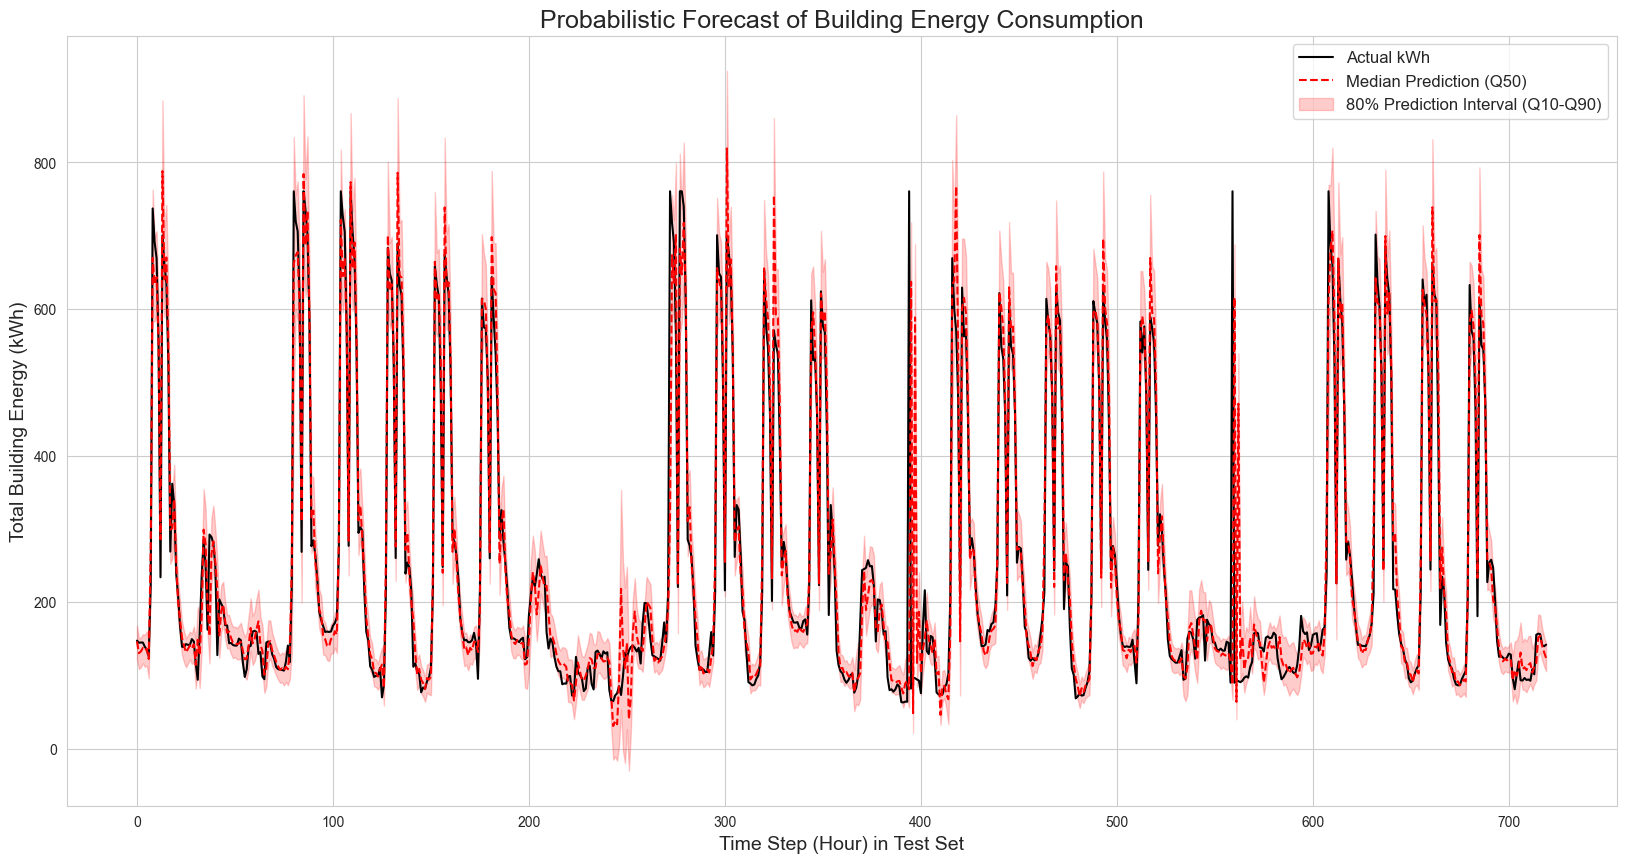


--- Final Probabilistic Model Performance ---
                                              Metric    Value
0                          Point Forecast RMSE (kWh)  55.1785
1                           Point Forecast MAE (kWh)  24.0603
2  Prediction Interval Coverage Probability (PICP %)  83.2580
3          Mean Prediction Interval Width (MPIW kWh)  70.2831
---------------------------------------------


In [7]:
# =============================================================================
# SECTION 5: EVALUATION AND VISUALIZATION OF UNCERTAINTY
# =============================================================================
#
# OBJECTIVE:
# To use our final, trained QR-PatchTST model to generate probabilistic
# forecasts on the unseen test data. We will then visualize these forecasts
# by plotting the prediction intervals and evaluate their quality using
# specialized probabilistic metrics.
#
# =============================================================================


# --- 5.1. Import Evaluation Libraries ---
#
# **CORRECTION**: Import the necessary functions from sklearn.metrics.
#
from sklearn.metrics import mean_squared_error, mean_absolute_error


# --- 5.2. Generate Quantile Predictions on the Test Set ---
#
# We use our trained 'final_model' to make predictions. Since the model was
# designed with three output neurons, it will directly output the three
# predicted quantiles in a single forward pass.
#
print("--- Generating Probabilistic Forecasts on Test Data ---")

# Predict the scaled quantiles
y_pred_scaled_quantiles = final_model.predict(X_test)

# Inverse transform the predictions to the original kWh scale
y_pred_quantiles = scaler_target.inverse_transform(y_pred_scaled_quantiles)

# Also, inverse transform the actual test values for comparison
y_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

print("Predictions generated and inverse-scaled successfully.")
print(f"Shape of predicted quantiles array: {y_pred_quantiles.shape}")
print("-------------------------------------------------------")


# --- 5.3. Organize Results into a DataFrame ---
#
# For easier analysis and plotting, we'll place our results into a pandas DataFrame.
#
results_df = pd.DataFrame({
    'Actual_kWh': y_actual.flatten(),
    'Pred_Q10': y_pred_quantiles[:, 0], # Lower bound (10th percentile)
    'Pred_Q50': y_pred_quantiles[:, 1], # Median (50th percentile)
    'Pred_Q90': y_pred_quantiles[:, 2]  # Upper bound (90th percentile)
})

print("\n--- Results DataFrame ---")
print(results_df.head())
print("-------------------------")


# --- 5.4. Visualize the Probabilistic Forecast ---
#
# This is the primary visualization for the paper. It shows not just the point
# forecast (the median) but also the uncertainty range (the prediction interval).
# We will plot a smaller slice of the test set for clarity.
#
plot_slice = 720 # Plot approximately one month of data

plt.figure(figsize=(20, 10))
plt.plot(results_df.index[:plot_slice], results_df['Actual_kWh'][:plot_slice], label='Actual kWh', color='black', linewidth=1.5)
plt.plot(results_df.index[:plot_slice], results_df['Pred_Q50'][:plot_slice], label='Median Prediction (Q50)', color='red', linestyle='--', linewidth=1.5)

# Add the shaded prediction interval
plt.fill_between(
    results_df.index[:plot_slice],
    results_df['Pred_Q10'][:plot_slice],
    results_df['Pred_Q90'][:plot_slice],
    color='red',
    alpha=0.2,
    label='80% Prediction Interval (Q10-Q90)'
)

plt.title('Probabilistic Forecast of Building Energy Consumption', fontsize=18)
plt.xlabel('Time Step (Hour) in Test Set', fontsize=14)
plt.ylabel('Total Building Energy (kWh)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# --- 5.5. Evaluate Probabilistic Metrics ---
#
# We now calculate the key metrics to quantitatively assess the quality of
# our probabilistic forecast: PICP and MPIW.
#
# 1. Prediction Interval Coverage Probability (PICP)
#    What percentage of actual values fall within the prediction interval?
#    For an 80% interval, the ideal PICP is 80%.
is_covered = (results_df['Actual_kWh'] >= results_df['Pred_Q10']) & (results_df['Actual_kWh'] <= results_df['Pred_Q90'])
picp = is_covered.mean() * 100

# 2. Mean Prediction Interval Width (MPIW)
#    What is the average width of the prediction intervals? A narrower
#    interval (for a given coverage) is better.
mpiw = (results_df['Pred_Q90'] - results_df['Pred_Q10']).mean()

# 3. Standard metrics for the median (point) forecast for reference
rmse = np.sqrt(mean_squared_error(results_df['Actual_kWh'], results_df['Pred_Q50']))
mae = mean_absolute_error(results_df['Actual_kWh'], results_df['Pred_Q50'])

# --- 5.6. Display Final Performance Metrics in a Table ---
performance_metrics = {
    'Metric': [
        'Point Forecast RMSE (kWh)',
        'Point Forecast MAE (kWh)',
        'Prediction Interval Coverage Probability (PICP %)',
        'Mean Prediction Interval Width (MPIW kWh)'
    ],
    'Value': [
        rmse,
        mae,
        picp,
        mpiw
    ]
}
performance_df = pd.DataFrame(performance_metrics)

print("\n--- Final Probabilistic Model Performance ---")
print(performance_df.round(4))
print("---------------------------------------------")

# SECTION 6: APPLICATION TO RISK-AWARE SUPERVISORY CONTROL

--- Risk-Aware Control Simulation ---
Operational Peak Threshold set to: 650.0 kWh
-------------------------------------

Simulation Results:
Standard Controller triggered 76 curtailment alerts.
Risk-Aware Controller triggered 304 curtailment alerts.

Found 228 critical events where the Risk-Aware controller
acted, but the Standard controller did not.

Examples of critical events (where standard controller failed to act):
    Actual_kWh    Pred_Q50    Pred_Q90
9       691.49  633.830017  697.760010
10      669.13  643.559998  706.239990
14      661.47  640.500000  706.469971
83      614.12  600.530029  687.679993
88      584.68  587.750000  659.219971
--------------------------------------------------------------------


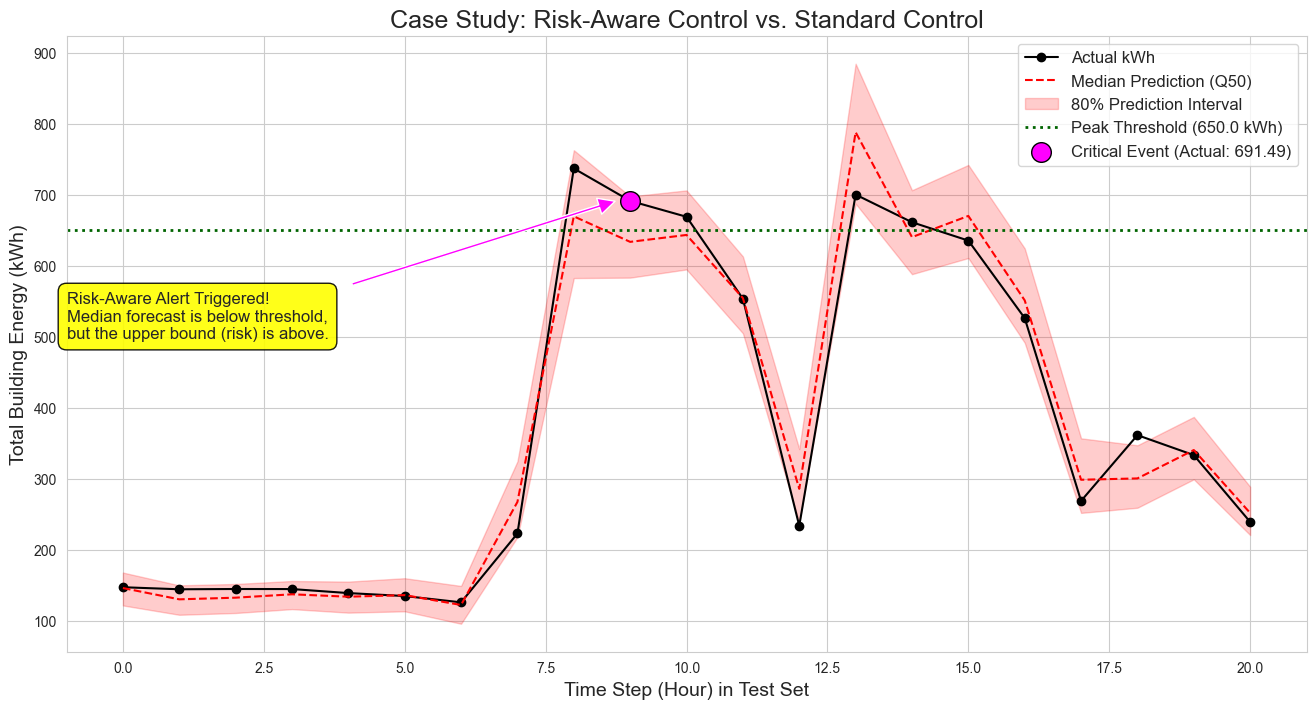

In [8]:
# =============================================================================
# SECTION 6: APPLICATION TO RISK-AWARE SUPERVISORY CONTROL
# =============================================================================
#
# OBJECTIVE:
# To demonstrate the practical, real-world value of our probabilistic
# forecasts. We will simulate a simple, risk-aware control strategy for
# managing peak load and compare its behavior to a standard controller that
# relies only on a single-point forecast.
#
# =============================================================================


# --- 6.1. Define the Control Scenario and Threshold ---
#
# Let's assume a scenario where the building operator wants to curtail load
# (e.g., by adjusting HVAC setpoints) whenever the hourly consumption is
# predicted to exceed a certain peak demand or high-cost tariff threshold.
#
PEAK_THRESHOLD_KWH = 650.0

print(f"--- Risk-Aware Control Simulation ---")
print(f"Operational Peak Threshold set to: {PEAK_THRESHOLD_KWH} kWh")
print("-------------------------------------")


# --- 6.2. Simulate and Compare Controller Actions ---
#
# We will compare two types of automated controllers based on our model's output.
#
# Controller 1: Standard (Median-Based)
# This controller acts only based on the most likely outcome (the median forecast).
results_df['Standard_Alert'] = results_df['Pred_Q50'] > PEAK_THRESHOLD_KWH

# Controller 2: Risk-Aware (Upper-Bound-Based)
# This controller is more cautious. It acts if there is a plausible risk (at least
# a 10% chance) that the load will exceed the threshold.
results_df['Risk_Aware_Alert'] = results_df['Pred_Q90'] > PEAK_THRESHOLD_KWH

# Calculate the number of alerts triggered by each controller
standard_alerts_count = results_df['Standard_Alert'].sum()
risk_aware_alerts_count = results_df['Risk_Aware_Alert'].sum()

print(f"\nSimulation Results:")
print(f"Standard Controller triggered {standard_alerts_count} curtailment alerts.")
print(f"Risk-Aware Controller triggered {risk_aware_alerts_count} curtailment alerts.")


# --- 6.3. Identify and Analyze Critical Disagreements ---
#
# The most interesting cases are when the Risk-Aware controller triggers an alert,
# but the Standard one does not. These represent events where uncertainty was high,
# and a standard forecast would have missed the potential peak.
#
critical_events = results_df[
    (results_df['Risk_Aware_Alert'] == True) & (results_df['Standard_Alert'] == False)
]

num_critical_events = len(critical_events)
print(f"\nFound {num_critical_events} critical events where the Risk-Aware controller")
print("acted, but the Standard controller did not.")

# Display the first few identified critical events for inspection
if not critical_events.empty:
    print("\nExamples of critical events (where standard controller failed to act):")
    print(critical_events[['Actual_kWh', 'Pred_Q50', 'Pred_Q90']].head().round(2))
else:
    print("No critical disagreement events found in the test set.")
print("--------------------------------------------------------------------")


# --- 6.4. Visualize a Case Study of a Critical Event ---
#
# We will create a focused plot to visually demonstrate the value of the
# risk-aware approach for the paper.
#
if not critical_events.empty:
    # Get the index of the first critical event for a clear plot
    event_index = critical_events.index[0]
    
    # Define a plotting window around the event for context
    plot_window_start = max(0, event_index - 12)
    plot_window_end = min(len(results_df), event_index + 12)
    
    plt.figure(figsize=(16, 8))
    
    # Plot the series data
    plt.plot(
        results_df.index[plot_window_start:plot_window_end],
        results_df['Actual_kWh'][plot_window_start:plot_window_end],
        label='Actual kWh', color='black', marker='o', linestyle='-'
    )
    plt.plot(
        results_df.index[plot_window_start:plot_window_end],
        results_df['Pred_Q50'][plot_window_start:plot_window_end],
        label='Median Prediction (Q50)', color='red', linestyle='--'
    )
    plt.fill_between(
        results_df.index[plot_window_start:plot_window_end],
        results_df['Pred_Q10'][plot_window_start:plot_window_end],
        results_df['Pred_Q90'][plot_window_start:plot_window_end],
        color='red', alpha=0.2, label='80% Prediction Interval'
    )
    
    # Highlight the operational threshold
    plt.axhline(y=PEAK_THRESHOLD_KWH, color='darkgreen', linestyle=':', linewidth=2, label=f'Peak Threshold ({PEAK_THRESHOLD_KWH} kWh)')
    
    # Highlight the specific critical event point
    plt.scatter(event_index, results_df.loc[event_index, 'Actual_kWh'], color='magenta', s=200, zorder=10, edgecolor='black', label=f'Critical Event (Actual: {results_df.loc[event_index, "Actual_kWh"]:.2f})')
    
    # Add an annotation to explain why this event is critical
    plt.annotate(
        'Risk-Aware Alert Triggered!\nMedian forecast is below threshold,\nbut the upper bound (risk) is above.',
        xy=(event_index, results_df.loc[event_index, 'Pred_Q90']),
        xytext=(event_index - 10, results_df.loc[event_index, 'Pred_Q90'] - 200),
        arrowprops=dict(facecolor='magenta', shrink=0.05, width=2),
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="yellow", ec="black", lw=1, alpha=0.9)
    )
    
    plt.title('Case Study: Risk-Aware Control vs. Standard Control', fontsize=18)
    plt.xlabel('Time Step (Hour) in Test Set', fontsize=14)
    plt.ylabel('Total Building Energy (kWh)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# SECTION 7 : Advanced Visualization

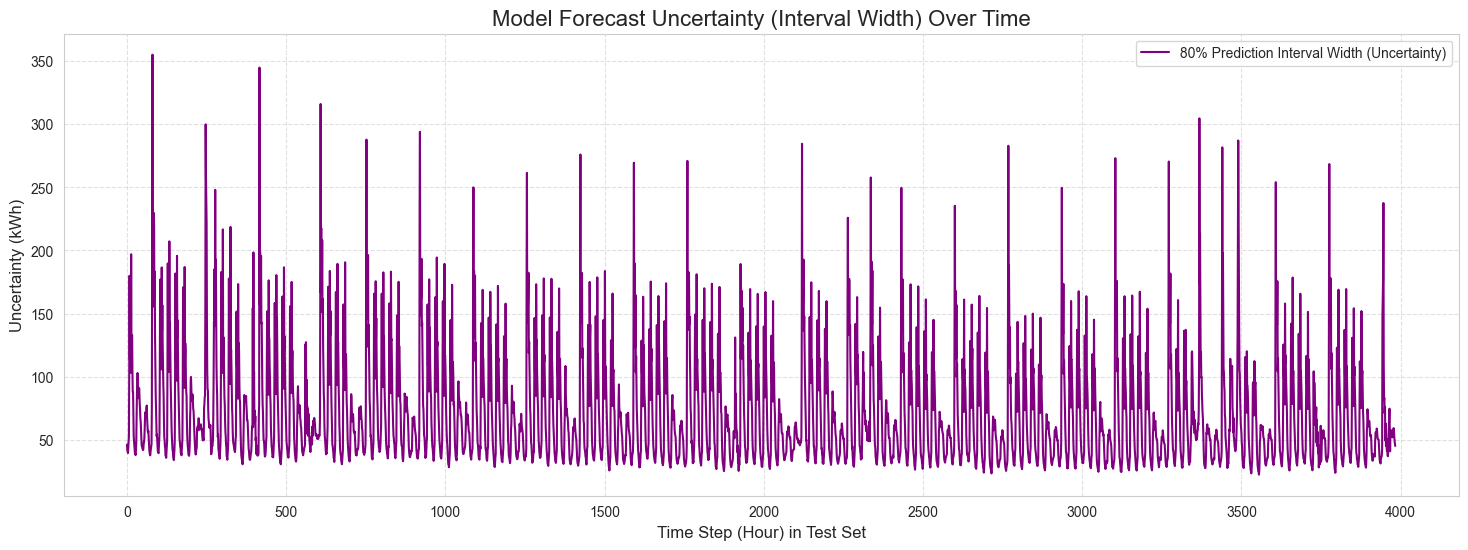


--- Summary Statistics for Forecast Uncertainty ---
count    3984.000000
mean       70.283127
std        41.855949
min        22.470947
25%        39.051180
50%        56.601711
75%        91.550957
max       354.965881
Name: Interval_Width, dtype: float64
---------------------------------------------


In [9]:
# =============================================================================
# SECTION 7 : Advanced Visualization
# =============================================================================

# --- 7.1. Plotting Forecast Uncertainty as a Time Series ---
#
# Calculate the width of the 80% prediction interval for each time step.
# This represents the model's uncertainty at that point in time.
results_df['Interval_Width'] = results_df['Pred_Q90'] - results_df['Pred_Q10']

plt.figure(figsize=(18, 6))
results_df['Interval_Width'].plot(
    color='purple',
    label='80% Prediction Interval Width (Uncertainty)'
)

plt.title('Model Forecast Uncertainty (Interval Width) Over Time', fontsize=16)
plt.xlabel('Time Step (Hour) in Test Set', fontsize=12)
plt.ylabel('Uncertainty (kWh)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Display summary statistics of the uncertainty
print("\n--- Summary Statistics for Forecast Uncertainty ---")
print(results_df['Interval_Width'].describe())
print("---------------------------------------------")

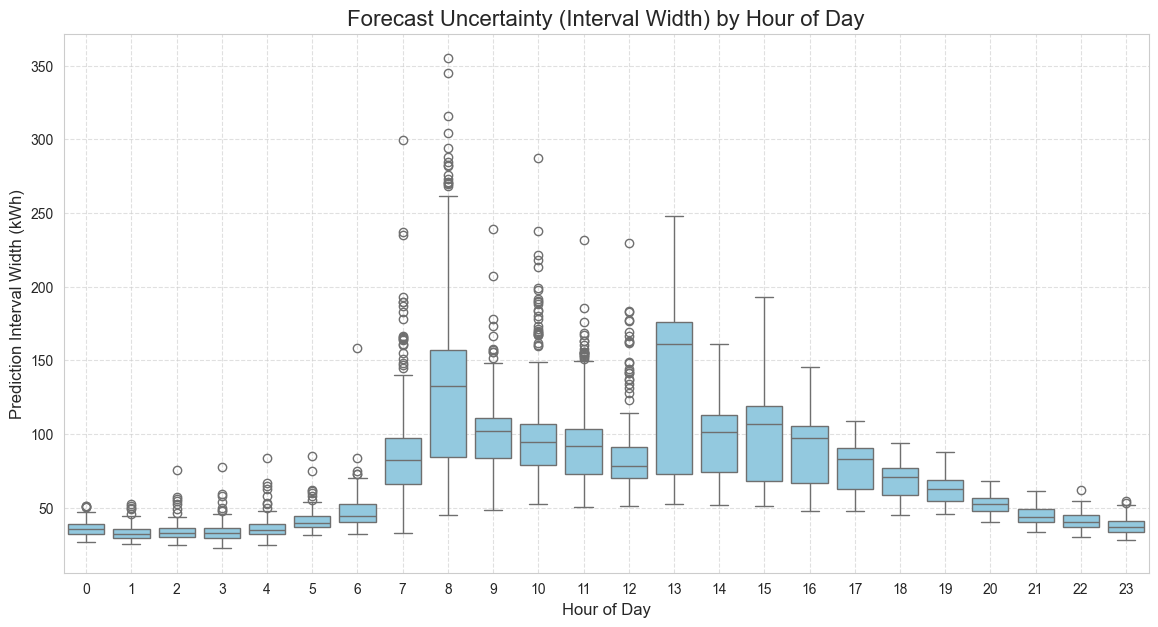

In [10]:
# --- 7.2. Analyzing Uncertainty by Hour of Day ---
#
# To understand the daily patterns in forecast uncertainty, we can create a
# boxplot of the interval width for each hour of the day.
#
# First, we need to get the hour of the day for the test set.
# The test set starts after the training set ends.
test_start_index = train_df.index[-1] + pd.Timedelta(hours=1)
test_indices = pd.date_range(start=test_start_index, periods=len(results_df), freq='h')
results_df['Hour'] = test_indices.hour

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=results_df,
    x='Hour',
    y='Interval_Width',
    color='skyblue'
)

plt.title('Forecast Uncertainty (Interval Width) by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Prediction Interval Width (kWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# SECTION 8: VALIDATION OF CONTROL STRATEGIES (CONTINGENCY ANALYSIS)

--- Contingency Analysis of Control Alert Performance ---
                          True Positives (Correct Alerts)  \
Controller Type                                             
Standard (Median-Based)                                44   
Risk-Aware (Upper Bound)                               88   

                          False Positives (False Alarms)  \
Controller Type                                            
Standard (Median-Based)                               32   
Risk-Aware (Upper Bound)                             216   

                          False Negatives (Critical Misses)  \
Controller Type                                               
Standard (Median-Based)                                  60   
Risk-Aware (Upper Bound)                                 16   

                          Total Alerts Triggered  
Controller Type                                   
Standard (Median-Based)                       76  
Risk-Aware (Upper Bound)                     304  

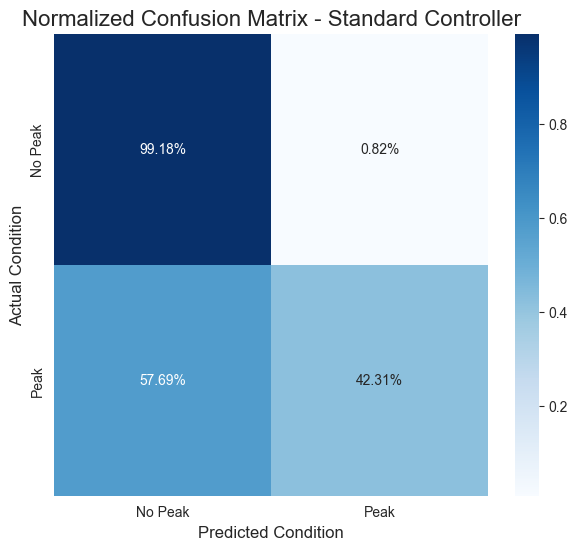

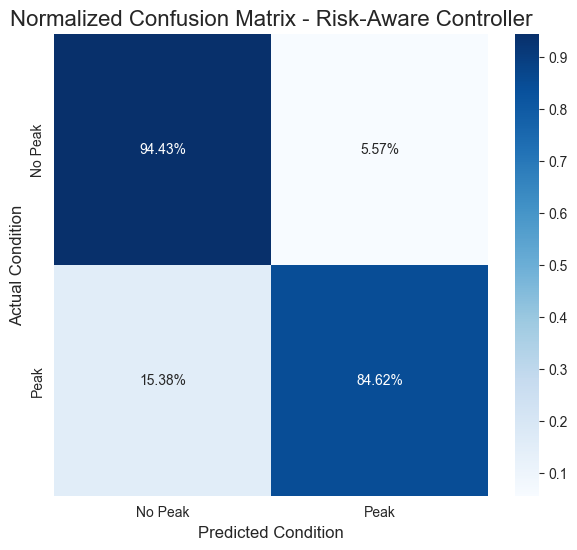

In [11]:
# =============================================================================
# SECTION 8: VALIDATION OF CONTROL STRATEGIES (CONTINGENCY ANALYSIS)
# =============================================================================
#
# OBJECTIVE:
# To rigorously validate the performance of the Standard vs. Risk-Aware
# control strategies. This involves comparing their alert triggers against the
# ground truth (actual peak exceedances) to quantify their effectiveness
# in terms of true positives, false positives, and critical misses.
#
# =============================================================================


# --- 8.1. Import Additional Libraries ---
#
# We need functions from sklearn.metrics to perform the contingency analysis.
#
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


# --- 8.2. Define the "Ground Truth" for Peak Events ---
#
# The ground truth is whether the actual energy consumption for a given hour
# truly exceeded our operational threshold.
#
results_df['Actual_Exceedance'] = results_df['Actual_kWh'] > PEAK_THRESHOLD_KWH

# --- 8.3. Calculate Contingency Metrics for Both Controllers ---
#
# We will now analyze the performance of each controller's alerts against
# the ground truth. A confusion matrix gives us:
#   - True Negatives (TN): Correctly did not alert.
#   - False Positives (FP): Incorrectly alerted (False Alarm).
#   - False Negatives (FN): Incorrectly did not alert (Critical Miss).
#   - True Positives (TP): Correctly alerted.
#

# --- For the Standard (Median-Based) Controller ---
tn_std, fp_std, fn_std, tp_std = confusion_matrix(
    results_df['Actual_Exceedance'],
    results_df['Standard_Alert']
).ravel()

# --- For the Risk-Aware (Upper-Bound-Based) Controller ---
tn_risk, fp_risk, fn_risk, tp_risk = confusion_matrix(
    results_df['Actual_Exceedance'],
    results_df['Risk_Aware_Alert']
).ravel()


# --- 8.4. Create the Summary Performance Table ---
#
# This table will be a key result in the paper's discussion, directly
# comparing the outcomes of the two strategies.
#
contingency_data = {
    'Controller Type': ['Standard (Median-Based)', 'Risk-Aware (Upper Bound)'],
    'True Positives (Correct Alerts)': [tp_std, tp_risk],
    'False Positives (False Alarms)': [fp_std, fp_risk],
    'False Negatives (Critical Misses)': [fn_std, fn_risk],
    'Total Alerts Triggered': [tp_std + fp_std, tp_risk + fp_risk]
}

contingency_df = pd.DataFrame(contingency_data).set_index('Controller Type')

print("--- Contingency Analysis of Control Alert Performance ---")
print(contingency_df)
print("-------------------------------------------------------")


# --- 8.5. Visualize Normalized Confusion Matrices ---
#
# A normalized confusion matrix is the best way to visualize the trade-offs
# between the controllers. It shows the percentage of correct/incorrect
# classifications for each class (Peak vs. No Peak).
#
def plot_normalized_confusion_matrix(y_true, y_pred, title):
    """Generates and plots a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2%', # Format as percentage with two decimals
        cmap='Blues',
        xticklabels=['No Peak', 'Peak'],
        yticklabels=['No Peak', 'Peak']
    )
    plt.title(title, fontsize=16)
    plt.ylabel('Actual Condition', fontsize=12)
    plt.xlabel('Predicted Condition', fontsize=12)
    plt.show()

# --- Generate the plots for the paper ---

# Plot for the Standard Controller
plot_normalized_confusion_matrix(
    results_df['Actual_Exceedance'],
    results_df['Standard_Alert'],
    title='Normalized Confusion Matrix - Standard Controller'
)

# Plot for the Risk-Aware Controller
plot_normalized_confusion_matrix(
    results_df['Actual_Exceedance'],
    results_df['Risk_Aware_Alert'],
    title='Normalized Confusion Matrix - Risk-Aware Controller'
)